<h1> On computing statistical moments (mean, variance, distributions) of a model </h1>

One of the main problems in uncertainty quantification is the parsimonious computation of statical moments; treating the model as a black box. In Effective Quadratures there are routines for achieveing prceisely that! In this notebook, we will consider the case where a user would like to estimate key statistical quantities using a numerical integration technique known as sparse grids.

First, we must define our *black box*. To ease our exposition, consider a oil flow ...

In [3]:
import numpy as np
from equadratures import *

In [4]:
def blackbox(x):
    return x[0]**2 + x[1]**2 + x[1]*x[0]*3.5 + 23

In [5]:
x1 = Parameter(distribution='Beta', lower=-2.5, upper=3.0, shape_parameter_A=1.5, shape_parameter_B=3.2, order=3)
x2 = Parameter(distribution='Gaussian', lower=-2.0, upper=3.0, shape_parameter_A=0, shape_parameter_B=0.2, order=4)
mybasis = Basis('Sparse grid', level=4, growth_rule='linear')

In [7]:
poly = Polyint([x1, x2], mybasis)
poly.computeCoefficients(blackbox)

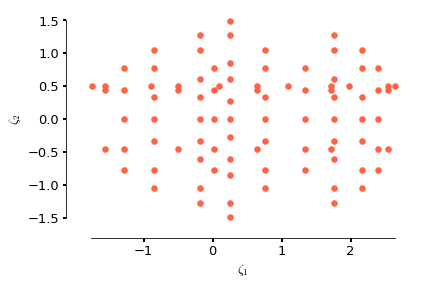

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.scatter(poly.quadraturePoints[:,0], poly.quadraturePoints[:,1] , marker='o', s=30, color='tomato')
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel('$\zeta_1$', fontsize=13)
plt.ylabel('$\zeta_2$', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

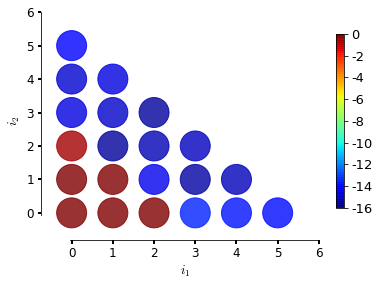

In [12]:
x, y, z, max_order = twoDgrid(poly.coefficients, poly.multi_index)
G = np.log10(np.abs(z))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cax = plt.scatter(x, y, s=900, marker='o', c=G, cmap='jet', alpha=0.8, vmin=-16, vmax=0)
plt.xlim(-0.5, max_order)
plt.ylim(-0.5, max_order)
adjust_spines(ax, ['left', 'bottom'])
ax.set_axisbelow(True)
plt.xlabel('$i_1$', fontsize=13)
plt.ylabel('$i_2$', fontsize=13)
cbar = plt.colorbar(extend='neither', spacing='proportional',
                orientation='vertical', shrink=0.8, format="%.0f")
cbar.ax.tick_params(labelsize=13)
plt.show()